In [1]:
import numpy as np
import matplotlib.pyplot as plt


class DenseLayer:
    def __init__(self, units=1, activation='relu'):
        self.units = units
        self.activation = activation.lower()
        self.w = None
        self.b = None
        self.input = None
        self.z = None

    def forward(self, x):
        self.input = x

        if self.w is None:
            fan_in = x.shape[-1]
            if self.activation in ['relu', 'leaky_relu']:
                std = np.sqrt(2.0 / fan_in)
            else:
                std = np.sqrt(1.0 / fan_in)
            self.w = np.random.normal(0.0, std, (fan_in, self.units))
            self.b = np.zeros(self.units)

        self.z = x @ self.w + self.b

        if self.activation == 'relu':
            return np.maximum(0, self.z)
        elif self.activation == 'leaky_relu':
            return np.maximum(0.01 * self.z, self.z)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-self.z))
        elif self.activation == 'tanh':
            return np.tanh(self.z)
        elif self.activation == 'softmax':
            exp_z = np.exp(self.z - np.max(self.z, axis=1, keepdims=True))
            return exp_z / np.sum(exp_z, axis=1, keepdims=True)
        elif self.activation == 'linear':
            return self.z
        elif self.activation == 'step':
            return (self.z >= 0).astype(float)
        else:
            raise ValueError(f"Неизвестная активация: {self.activation}")

    def derivative(self, a):
        if self.activation == 'relu':
            return (self.z > 0).astype(float)
        elif self.activation == 'leaky_relu':
            return (self.z > 0).astype(float) + 0.01 * (self.z <= 0).astype(float)
        elif self.activation == 'sigmoid':
            return a * (1 - a)
        elif self.activation == 'tanh':
            return 1 - a**2
        elif self.activation in ('linear', 'step'):
            return np.ones_like(a)
        elif self.activation == 'softmax':
            return np.ones_like(a)
        return np.ones_like(a)


class Input:
    def __init__(self, shape=None):
        self.shape = shape

    def forward(self, x):
        if self.shape is not None:
            expected = self.shape if isinstance(self.shape, tuple) else (self.shape,)
            if x.shape[1:] != expected:
                x = x.reshape((x.shape[0],) + expected)
        return x


class Sequential:
    def __init__(self, layers):
        self.layers = layers
        self.history_mse = []

    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer.forward(out)
        return out

    def fit(self, x_input, y_input, epochs=100, alpha=0.001,
            clip_value=5.0, adaptive_alpha=False, Ee=1e-5):
        x_input = np.asarray(x_input, dtype=np.float32)
        y_input = np.asarray(y_input, dtype=np.float32).reshape(-1, 1)

        n_samples = x_input.shape[0]
        self.history_mse = []

        for epoch in range(epochs):
            mse_sum = 0.0

            indices = np.random.permutation(n_samples)
            x_shuffled = x_input[indices]
            y_shuffled = y_input[indices]

            for i in range(n_samples):
                x = x_shuffled[i:i+1]
                y = y_shuffled[i:i+1]

                if adaptive_alpha:
                  alpha_t = 1.0 / (1 + np.sum(x ** 2))
                else:
                  alpha_t = alpha

                activations = [x]
                for layer in self.layers:
                    a = layer.forward(activations[-1])
                    activations.append(a)

                pred = activations[-1]
                mse_sum += np.mean((pred - y) ** 2)

                delta = pred - y

                if self.layers[-1].activation == 'step':
                    delta = y - pred

                for l in range(len(self.layers) - 1, -1, -1):
                    layer = self.layers[l]

                    if not hasattr(layer, 'activation'):
                        continue

                    a_prev = activations[l]

                    if layer.activation == 'step':
                        grad_w = a_prev.T @ delta
                        grad_b = np.sum(delta, axis=0)
                    else:
                        da = layer.derivative(activations[l+1])
                        delta = delta * da
                        grad_w = a_prev.T @ delta
                        grad_b = np.sum(delta, axis=0)

                    grad_w = np.clip(grad_w, -clip_value, clip_value)
                    grad_b = np.clip(grad_b, -clip_value, clip_value)

                    layer.w += alpha_t * grad_w
                    layer.b += alpha_t * grad_b

                    delta = delta @ layer.w.T

            avg_mse = mse_sum / n_samples
            self.history_mse.append(avg_mse)

            if epoch % 3 == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch:4d} | MSE = {avg_mse:.6f}")

            if avg_mse <= Ee:
              print(f"Достигнут критерий остановки: {avg_mse} <= {Ee}")
              break

    def predict(self, x):
        x = np.asarray(x, dtype=np.float32)
        if x.ndim == 1:
            x = x.reshape(1, -1)
        return self.forward(x)

In [2]:
model_fixed = Sequential([
    Input(),
    DenseLayer(1, 'step'),
])

model_adapt = Sequential([
    Input(),
    DenseLayer(1, 'step'),
])

x = np.array([[4, 6], [-4, 6], [4, -6], [-4, -6]], dtype=np.float32)
y = [0, 1, 1, 1]

In [3]:
model_fixed.fit(x, y, alpha=0.01, adaptive_alpha=False, Ee=1e-3)

Epoch    0 | MSE = 0.750000
Epoch    3 | MSE = 1.000000
Epoch    6 | MSE = 0.750000
Достигнут критерий остановки: 0.0 <= 0.001


In [4]:
model_adapt.fit(x, y, alpha=0.01, adaptive_alpha=True, Ee=1e-3)

Epoch    0 | MSE = 0.750000
Epoch    3 | MSE = 0.250000
Epoch    6 | MSE = 0.500000
Epoch    9 | MSE = 0.000000
Достигнут критерий остановки: 0.0 <= 0.001


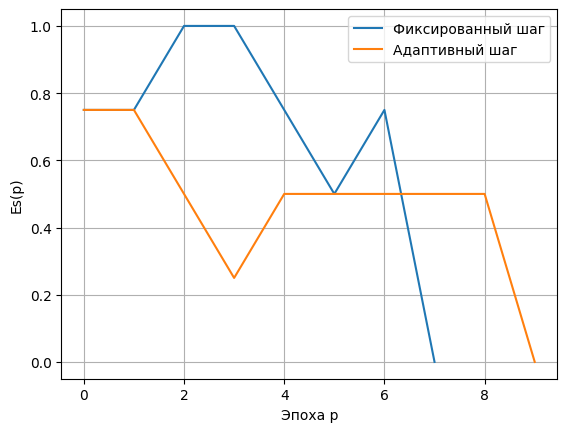

In [5]:
plt.plot(model_fixed.history_mse, label="Фиксированный шаг")
plt.plot(model_adapt.history_mse, label="Адаптивный шаг")

plt.xlabel("Эпоха p")
plt.ylabel("Es(p)")
plt.legend()
plt.grid()
plt.show()

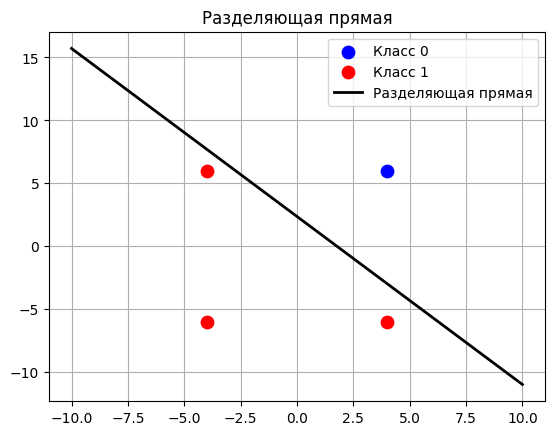

In [6]:
y = np.array(y)

w = model_adapt.layers[1].w
b = model_adapt.layers[1].b

x_line = np.linspace(-10, 10, 200)
y_line = -(w[0]/w[1]) * x_line - b[0]/w[1]

plt.scatter(
    x[y == 0, 0],
    x[y == 0, 1],
    color='blue',
    s=80,
    label='Класс 0'
)

plt.scatter(
    x[y == 1, 0],
    x[y == 1, 1],
    color='red',
    s=80,
    label='Класс 1'
)

plt.plot(
    x_line, y_line,
    'k-', linewidth=2,
    label='Разделяющая прямая'
)

plt.grid(True)
plt.title("Разделяющая прямая")
plt.legend()
plt.show()

Введите x1 и x2: 7 -6
Класс: 0, прогноз модели: 0.0000


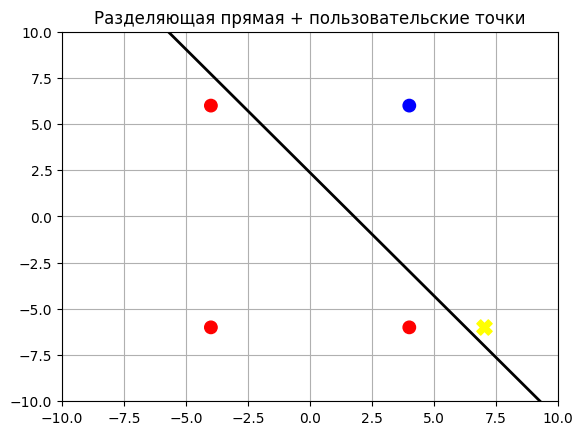

Желаете продолжить? (y/n) n


In [8]:
import matplotlib.pyplot as plt

user_points = []
user_classes = []

while True:
    s = list(map(float, input("Введите x1 и x2: ").split()))

    point = np.array(s, dtype=np.float32)
    x1, x2 = point[0], point[1]

    prediction = model_adapt.predict(point.reshape(1, -1)).item()
    cls = int(prediction > 0.5)

    print(f"Класс: {cls}, прогноз модели: {prediction:.4f}")

    user_points.append([x1, x2])
    user_classes.append(cls)

    plt.clf()

    plt.scatter(x[:,0], x[:,1], c=y, cmap='bwr', s=80)

    for (px, py), c in zip(user_points, user_classes):
        color = "green" if c == 1 else "yellow"
        plt.scatter([px], [py], c=color, s=120, marker='X')

    plt.plot(x_line, y_line, 'k-', linewidth=2)
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.grid(True)
    plt.title("Разделяющая прямая + пользовательские точки")

    plt.pause(0.01)

    if input("Желаете продолжить? (y/n) ") == "n":
        break